In [1]:
from importlib import reload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('./dracula.mplstyle')
import logging
LOG = logging.getLogger(__name__)
LOG.setLevel(logging.INFO)
LOG.info('Hello from notebook')

from pydataset import data

import frankenfit as ff

logging.getLogger('frankenfit').setLevel(logging.INFO)

In [2]:
df = data('diamonds').reset_index().drop(['index'], axis=1)
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [3]:
from sklearn.linear_model import LinearRegression

FEATURES = ["carat", "x", "y", "z", "depth", "table"]

def bake_features(cols):
    return (
        ff.DataFramePipeline()
        .print(fit_msg=f"Baking: {cols}")
        .winsorize(cols, limit=0.05)
        .z_score(cols)
        .impute_constant(cols, 0.0)
        .clip(cols, upper=2, lower=-2)
    )

pipeline = (
    ff.DataFramePipeline()
    [FEATURES + ["{response_col}"]]
    .copy("{response_col}", "{response_col}_train")
    .winsorize("{response_col}_train", limit=0.05)
    .pipe(["carat", "{response_col}_train"], np.log1p)
    .if_hyperparam_is_true("bake_features", bake_features(FEATURES))
    .sk_learn(
        LinearRegression,
        # x_cols=["carat", "depth", "table"],
        x_cols=ff.HP("predictors"),
        response_col="{response_col}_train",
        hat_col="{response_col}_hat",
        class_params={"fit_intercept": True},
    )
    # transform {response_col}_hat from log-dollars back to dollars
    .copy("{response_col}_hat", "{response_col}_hat_dollars")
    .pipe("{response_col}_hat_dollars", np.expm1)
)
pipeline.hyperparams()

{'bake_features', 'predictors', 'response_col'}

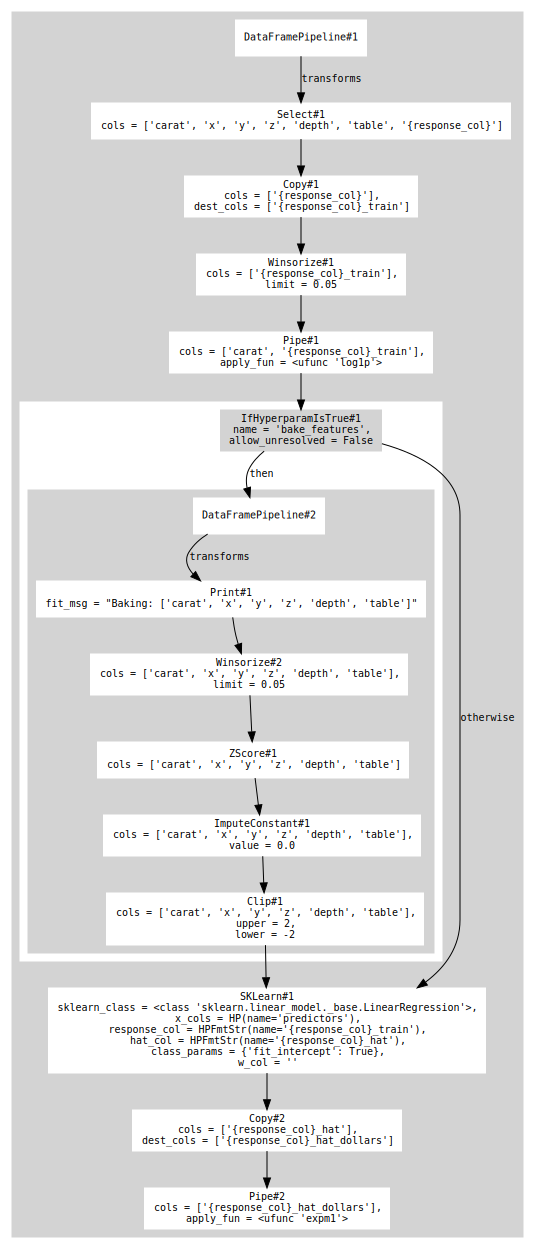

In [4]:
pipeline.visualize()

In [5]:
ff.dataframe.Correlation?

Init signature:
ff.dataframe.Correlation(
    left_cols: 'X',
    right_cols: 'X',
    method: 'Optional[str | HP]' = 'pearson',
    min_obs: 'Optional[int]' = 1,
    *,
    tag: 'str' = NOTHING,
) -> None
Docstring:     
Compute the correlation between each pair of columns in the cross-product of
``left_cols`` and ``right_cols``.

:param left_cols: List of "left" correlands. Result will have one row per element of
    ``left_cols``.
:param right_cols: List of "right" correlands. Result will have one column per
    element of ``right_cols``.
:param method: One of ``"pearson"``, ``"spearman"``, or ``"kendall"``, specifying
    which type of correlation coefficient to compute.
:param min_obs: The minimum number of non-missing values for each pair of columns.
    If a pair has fewer than this many non-missing observations, then the
    correlation for that pair will be missing in the result.

Example::

    from pydataset import data
    df = data("diamonds")
    ff.Correlation(["price"],

In [6]:
pipcorr = (pipeline + ff.dataframe.Correlation(["{response_col}"], ["{response_col}_hat_dollars"]))
pipcorr.hyperparams()

{'bake_features', 'predictors', 'response_col'}

In [7]:
pipcorr.apply(
    df,
    bindings={
        'bake_features': True,
        'response_col': 'price',
        'predictors': ["depth", "table", ]
    }
)

Baking: ['carat', 'x', 'y', 'z', 'depth', 'table']


,price_hat_dollars
price,0.13719


In [9]:
print(ff.dataframe.Correlation(["price"], ["carat", "table", "depth"]).apply(df))

          carat     table     depth
price  0.921591  0.127134 -0.010647


In [10]:
print(ff.dataframe.Correlation(["table", "depth"], ["x", "y", "z"]).apply(df))

              x         y         z
table  0.195344  0.183760  0.150929
depth -0.025289 -0.029341  0.094924


In [11]:
n_folds = 5
cv = (
    ff.DataFramePipeline()
    .stateless_lambda(lambda df: df.assign(cv_grp=df.index % n_folds))
    .group_by('cv_grp', fitting_schedule=ff.fit_group_on_all_other_groups)
        .then(
            pipeline
            .correlation(
                ['{response_col}'],
                ['{response_col}_hat_dollars'],
            )
        )
)
cv.apply(
    df,
    bindings={
        'bake_features': True,
        'response_col': 'price',
        'predictors': ["depth", "table", ]
    }
)

Baking: ['carat', 'x', 'y', 'z', 'depth', 'table']
Baking: ['carat', 'x', 'y', 'z', 'depth', 'table']
Baking: ['carat', 'x', 'y', 'z', 'depth', 'table']
Baking: ['carat', 'x', 'y', 'z', 'depth', 'table']
Baking: ['carat', 'x', 'y', 'z', 'depth', 'table']


,price_hat_dollars
price,0.139010
price,0.139238
price,0.130875
price,0.139207
price,0.137272


In [12]:
cv.apply(
    df,
    bindings={
        'bake_features': False,
        'response_col': 'price',
        'predictors': ["depth", "table", ]
    }
)

,price_hat_dollars
price,0.116949
price,0.119469
price,0.101260
price,0.111865
price,0.124630


In [13]:
n_folds = 5
def add_cv_grp(df):
    return df.assign(cv_grp = df.index % n_folds)

cv = (
    ff.DataFramePipeline()
    .stateless_lambda(add_cv_grp)
    .group_by('cv_grp', fitting_schedule=ff.fit_group_on_all_other_groups)
        .then(
            pipeline
        )
    .correlation(
        ['{response_col}'],
        ['{response_col}_hat_dollars'],
    )
)
cv.apply(
    df,
    bindings={
        'bake_features': True,
        'response_col': 'price',
        'predictors': ["depth", "table", ]
    }
)

Baking: ['carat', 'x', 'y', 'z', 'depth', 'table']
Baking: ['carat', 'x', 'y', 'z', 'depth', 'table']
Baking: ['carat', 'x', 'y', 'z', 'depth', 'table']
Baking: ['carat', 'x', 'y', 'z', 'depth', 'table']
Baking: ['carat', 'x', 'y', 'z', 'depth', 'table']


,price_hat_dollars
price,0.137087


In [14]:
cv.apply(
    df,
    bindings={
        'bake_features': False,
        'response_col': 'price',
        'predictors': ["depth", "table", ]
    }
)

,price_hat_dollars
price,0.112941


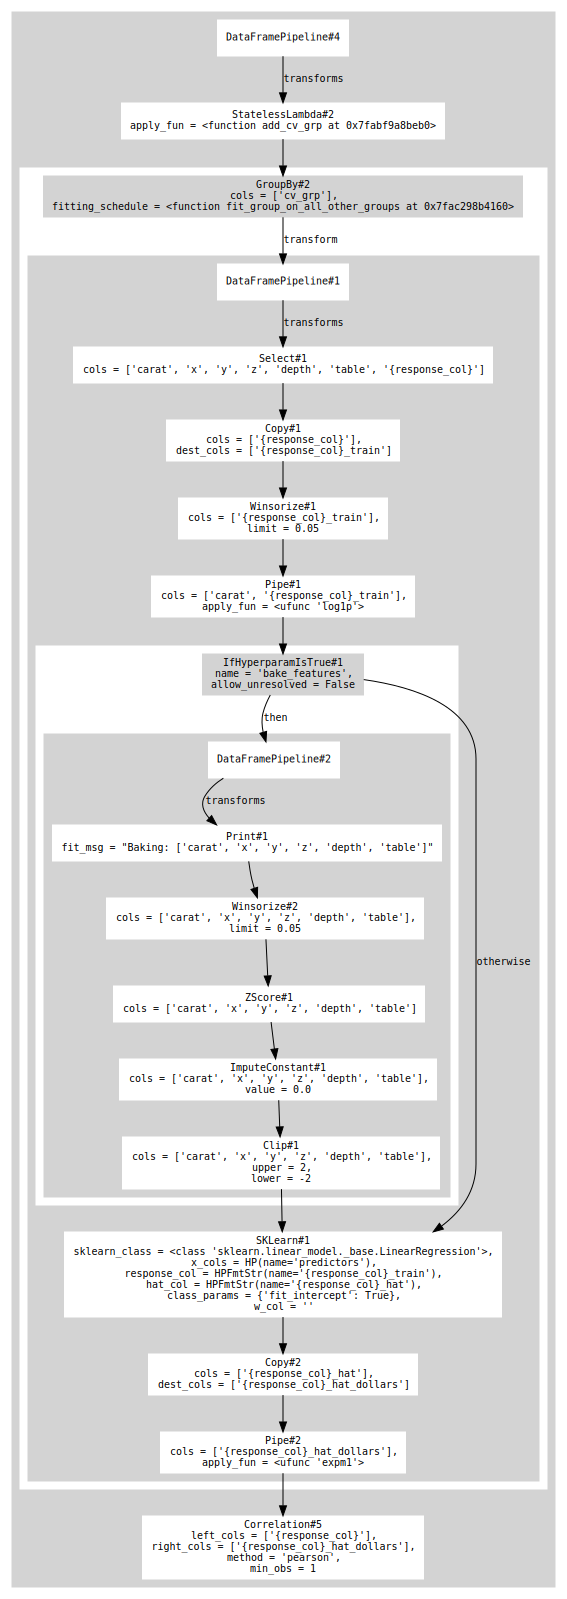

In [15]:
cv.visualize()